In [1]:
%pylab inline

import numpy as np
import tensorflow as tf

from scipy import integrate
from scipy.io import loadmat
from mpl_toolkits.mplot3d import Axes3D

import keras
from keras import optimizers
from keras.models import Model,Sequential,load_model
from keras.layers import Input,Dense,Convolution1D,Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from keras.utils import plot_model

from IPython.display import clear_output

Populating the interactive namespace from numpy and matplotlib


/home/tyler/anaconda3/envs/tensorflowGPU/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.yscale('log')
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

def rad_bas(x):
    return K.exp(-x**2)
get_custom_objects().update({'rad_bas': Activation(rad_bas)})

def tan_sig(x):
    return 2/(1+K.exp(-2*x))-1
get_custom_objects().update({'tan_sig': Activation(tan_sig)})

In [3]:
def progress_bar(percent):
    length = 40
    pos = round(length*percent)
    clear_output(wait=True)
    print('['+'█'*pos+' '*(length-pos)+']  '+str(int(100*percent))+'%')

## Load KS trajectories

In [4]:
N = 1024
T = 251
num_iter = 40
num_tests = 1
KS_input_data = np.zeros(((T-1)*(num_iter-num_tests),N))
KS_target_data = np.zeros(((T-1)*(num_iter-num_tests),N))

for i in range(num_iter-num_tests):
    u = loadmat('PDECODES/KS_data/N'+str(N)+'/iter'+str(i+1)+'.mat')['uu']
    KS_input_data[i*(T-1):(i+1)*(T-1)] = u[:,:-1].T
    KS_target_data[i*(T-1):(i+1)*(T-1)] = u[:,1:].T

In [5]:
KS_test_data = np.zeros((T*num_tests,N))
for i in range(num_tests):
    u = loadmat('PDECODES/KS_data/N'+str(N)+'/iter'+str(num_iter-i)+'.mat')['uu']
    KS_test_data[i*T:(i+1)*T] = u.T

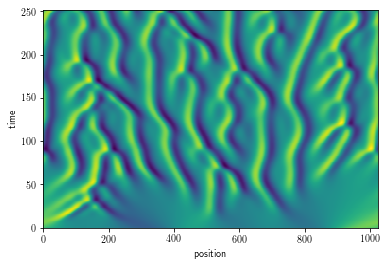

In [6]:
mpl.rcParams['text.usetex'] = True
m = plt.pcolormesh(KS_test_data)
m.set_rasterized(True)
plt.xlabel('position')
plt.ylabel('time')
plt.savefig('img/sample_KS_trajectory.pdf')

## Train Neural Network

In [40]:
model = Sequential()
model.add(Dense(2*N, activation='tan_sig', use_bias=True, input_shape=(N,)))
#model.add(Dense(2*N, activation='sigmoid', use_bias=True))
#model.add(Dense(2*N, activation='linear', use_bias=True))
model.add(Dense(N))

In [41]:
sgd1 = keras.optimizers.SGD(lr=0.001, decay=1e-15, momentum=1, nesterov=True)
adam1 = keras.optimizers.Adam(lr=.02, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-4, amsgrad=True, clipvalue=0.5)
nadam1 = keras.optimizers.Nadam(lr=0.02, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
rmsprop1 = keras.optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=0.0)

In [42]:
model.compile(loss='mean_squared_error', optimizer=adam1, metrics=['accuracy'])
#plot_model(model, to_file='model.pdf', show_shapes=True)

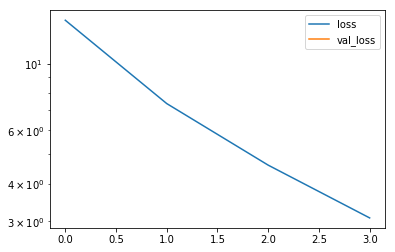

Epoch 5/1000
3000/9750 [========>.....................] - ETA: 0s - loss: 2.2335 - acc: 0.0130

KeyboardInterrupt: 

In [45]:
mpl.rcParams['text.usetex'] = False
model.fit(
    KS_input_data,
    KS_target_data,
    epochs=1000, batch_size=3000, shuffle=True, callbacks=[plot_losses], validation_split=0.0)

In [ ]:
KS_NN_prediction = np.zeros(KS_test_data[0:T].shape)
KS_NN_prediction[0] = KS_test_data[0]
for k in range(T-1):
    KS_NN_prediction[k+1] = model.predict(np.array([KS_NN_prediction[k]]))

In [ ]:
mpl.rcParams['text.usetex'] = True
m = plt.pcolormesh(KS_NN_prediction)
m.set_rasterized(True)
plt.xlabel('position')
plt.ylabel('time')
plt.savefig('img/predicted_KS_trajectory.pdf')

In [ ]:
KS_input_data.shape